In [1]:
#!pip install arch

In [2]:
#!pip install statsforecast

In [3]:
#!pip install StatsForecast

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import norm, skew #for some statistics
from scipy import stats
from os import walk
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import ARResults
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product
"""from arch import arch_model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
import warnings
warnings.filterwarnings('ignore')
#from statsforecast import StatsForecast
#from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)"""
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_excel('ORDER_RECIPE1.xls')
df

,ORDER_ID,COMPARTMENT_ID,ORDER_RECIPE_ID,BAY_CODE,API_CODE,INJECTOR_PRESET_CODE,TANK_CODE,PRODUCT_GROUP_CODE,INJECTOR_CODE,METER_CODE,...,ADJUSTMENT_BATCH,COMPARTMENT_OWNER_ID,COMPARTMENT_CONTAINER_CODE,COMPARTMENT_CONTAINER_TYPE,BLEND_CORRECTION_METHOD,BLEND_CORRECTION_NET_VOLUME,TOTAL_BATCH_BLEND_NET_VOLUME,BLEND_CORRECTION_SOURCE,COMMODITY_GROUP,DERIVATION_STATUS
0,8320,8342,8343,NaN,54B,NaN,NaN,DSL,NaN,NaN,...,2,NaN,NaN,NaN,0,0,0,0,2,0
1,8320,8344,8345,NaN,54B,NaN,NaN,DSL,NaN,NaN,...,2,NaN,NaN,NaN,0,0,0,0,2,0
2,8320,8346,8347,NaN,54B,NaN,NaN,DSL,NaN,NaN,...,2,NaN,NaN,NaN,0,0,0,0,2,0
3,8320,8348,8349,BAY_300,54B,NaN,TK-205,DSL,NaN,MTR_301,...,2,0.0,TK-205,1.0,0,0,0,0,2,0
4,8320,8350,8351,NaN,54B,NaN,NaN,DSL,NaN,NaN,...,2,NaN,NaN,NaN,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,389752,389780,390107,BAY_200,54B,NaN,TK-205,DSL,NaN,MTR_201,...,2,0.0,TK-205,1.0,0,0,0,0,2,0
65531,389752,389782,389783,BAY_200,54B,NaN,TK-205,DSL,NaN,MTR_201,...,2,0.0,TK-205,1.0,0,0,0,0,2,0
65532,389752,389782,390308,BAY_200,54B,NaN,TK-205,DSL,NaN,MTR_201,...,2,0.0,TK-205,1.0,0,0,0,0,2,0
65533,389786,389806,389807,BAY_400,54B,NaN,TK-205,DSL,NaN,MTR_401,...,2,0.0,TK-205,1.0,0,0,0,0,2,0


In [18]:
df['START_TIME'].min() , df['END_TIME'].min()

(Timestamp('2021-09-24 14:21:46'), Timestamp('2021-09-24 14:23:10'))

In [19]:
df['START_TIME'].min() , df['END_TIME'].min()

(Timestamp('2021-09-24 14:21:46'), Timestamp('2021-09-24 14:23:10'))

In [20]:
fassakh=df.isnull().sum()
print(fassakh[fassakh > 0])

BAY_CODE                       3208
INJECTOR_PRESET_CODE          49626
TANK_CODE                      3208
INJECTOR_CODE                 49626
METER_CODE                    19117
START_TIME                     3259
END_TIME                       3259
METER_PRESET_CODE             19117
COMPARTMENT_OWNER_ID           3208
COMPARTMENT_CONTAINER_CODE     3208
COMPARTMENT_CONTAINER_TYPE     3208
dtype: int64


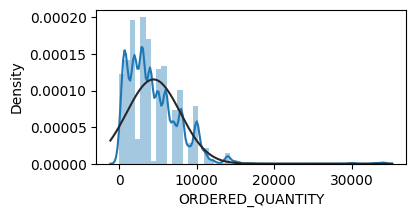

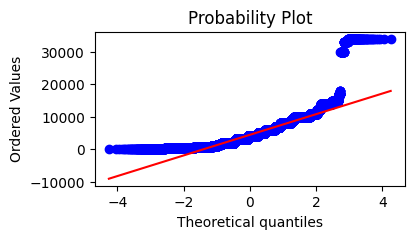

In [21]:
rcParams['figure.figsize'] = 4,2
sns.distplot(df['ORDERED_QUANTITY'], fit=norm)
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['ORDERED_QUANTITY'], plot=plt)
plt.show()

In [25]:
columns_list = df.columns.tolist()

# Printing the list of columns
print(columns_list)

['ORDER_ID', 'COMPARTMENT_ID', 'ORDER_RECIPE_ID', 'BAY_CODE', 'API_CODE', 'INJECTOR_PRESET_CODE', 'TANK_CODE', 'PRODUCT_GROUP_CODE', 'INJECTOR_CODE', 'METER_CODE', 'SUPPLIER_NUMBER', 'TERMINAL_PRODUCT_NUMBER', 'TERMINAL_PRODUCT_TYPE', 'BLEND_PERCENT', 'RATE', 'ORDERED_QUANTITY', 'OVERRIDE_TEMPERATURE_ENABLE', 'GROSS_QUANTITY', 'WEIGHT', 'NET_QUANTITY', 'DENSITY', 'CUSTOMER_NET_QUANTITY', 'SPECIFIC_GRAVITY', 'COEFFICIENT_EXPANSION', 'TEMPERATURE', 'RVP', 'OXYGEN', 'START_GROSS_TOTALIZER', 'END_GROSS_TOTALIZER', 'START_NET_TOTALIZER', 'END_NET_TOTALIZER', 'START_WEIGHT', 'END_WEIGHT', 'START_TIME', 'END_TIME', 'ADDITIVE_QUANTITY', 'PRODUCT_QUANTITY', 'FROM_LEFT_ON_TRUCK', 'OBSERVED_DENSITY', 'COMPONENT_ID', 'CALCULATE_SECONDARY_UNITS', 'FRAC_START_GROSS_TOTALIZER', 'FRAC_END_GROSS_TOTALIZER', 'PRODUCT_TOLERANCE_STATUS', 'TANK_INVENTORY_UPDATED', 'TOTALIZER_UPDATED', 'FLUSH_STATUS', 'ADDITIVE_WEIGHT', 'PRODUCT_WEIGHT', 'RT_INJECTOR_ALARM_COUNT', 'BATCH_NUMBER', 'ADDITIVE_MASKING', 'COMPAT

In [28]:
df1 = df.drop(['COMPARTMENT_ID', 'PDXR_AUTHORIZATION_UNITS', 'MEASURED_QUANTITY_TYPE', 'COMMITTED_CONV_COE', 'COMMITTED_CONV_PRESSURE',
               'INVENTORY_QUANTITY_TYPE', 'DERIVED_VALUES_DIRECTIVE', 'ADJUSTMENT_BATCH', 'COMMODITY_GROUP', 'CALCULATE_NET',
               'DERIVATION_STATUS', 'TOTAL_BATCH_BLEND_NET_VOLUME', 'PRESSURE', 'NON_RECIPE_WEIGHT_IN_VAC', 'BLEND_CORRECTION_METHOD',
               'BLEND_CORRECTION_NET_VOLUME', 'BLEND_CORRECTION_SOURCE', 'ORDER_ID', 'ORDER_RECIPE_ID', 'API_CODE', 'INJECTOR_PRESET_CODE', 'INJECTOR_CODE', 'BAY_CODE',
               'TANK_CODE', 'METER_CODE', 'COMPARTMENT_OWNER_ID', 'COMPARTMENT_CONTAINER_CODE', 'COMPARTMENT_CONTAINER_TYPE',
               'INJECTOR_CODE', 'COMPONENT_ID', 'CALCULATE_SECONDARY_UNITS', 'FRAC_START_GROSS_TOTALIZER',
               'PRODUCT_TOLERANCE_STATUS', 'TANK_INVENTORY_UPDATED', 'TOTALIZER_UPDATED', 'FLUSH_STATUS', 'ADDITIVE_WEIGHT', 'PRODUCT_WEIGHT',
               'RT_INJECTOR_ALARM_COUNT', 'BATCH_NUMBER', 'ADDITIVE_MASKING', 'COMPATIBILITY_STATUS', 'RECIPE_CORRECTION_TYPE',
               'NON_RECIPE_GROSS_QUANTITY', 'NON_RECIPE_NET_QUANTITY', 'NON_RECIPE_WEIGHT', 'ADDITIVE_WEIGHT_IN_VAC', 'PRODUCT_WEIGHT_IN_VAC',
               'COMMITTED_GROSS_QUANTITY', 'PRODUCT_WEIGHT_IN_VAC', 'COMMITTED_NET_QUANTITY', 'PDXR_AUTHORIZATION_UNITS',
               'COMMITTED_WEIGHT_IN_VAC', 'COMMITTED_WEIGHT_IN_AIR', 'COMMITTED_CONV_TEMPERATURE', 'COMMITTED_CONV_DENSITY', 'COMMITTED_CONV_COE',
               'COMMITTED_CONV_PRESSURE', 'MEASURED_QUANTITY_TYPE', 'INVENTORY_QUANTITY_TYPE', 'DERIVED_VALUES_DIRECTIVE', 'PRESSURE',
               'METER_PRESET_CODE', 'CALCULATE_NET', 'NON_RECIPE_WEIGHT_IN_VAC', 'ADJUSTMENT_BATCH', 'COMPARTMENT_OWNER_ID', 'COMPARTMENT_CONTAINER_CODE',
               'COMPARTMENT_CONTAINER_TYPE', 'BLEND_CORRECTION_METHOD', 'BLEND_CORRECTION_NET_VOLUME', 'BLEND_CORRECTION_SOURCE',
               'COMMODITY_GROUP', 'DERIVATION_STATUS'], axis=1)
df1


,PRODUCT_GROUP_CODE,SUPPLIER_NUMBER,TERMINAL_PRODUCT_NUMBER,TERMINAL_PRODUCT_TYPE,BLEND_PERCENT,RATE,ORDERED_QUANTITY,OVERRIDE_TEMPERATURE_ENABLE,GROSS_QUANTITY,WEIGHT,...,START_WEIGHT,END_WEIGHT,START_TIME,END_TIME,ADDITIVE_QUANTITY,PRODUCT_QUANTITY,FROM_LEFT_ON_TRUCK,OBSERVED_DENSITY,FRAC_END_GROSS_TOTALIZER,WEIGHT_IN_VAC
0,DSL,12,7,1,100,0,100,0,0,0,...,0,0,NaT,NaT,0,0,2,0,0,0
1,DSL,12,7,1,100,0,100,0,0,0,...,0,0,NaT,NaT,0,0,2,0,0,0
2,DSL,12,7,1,100,0,100,0,0,0,...,0,0,NaT,NaT,0,0,2,0,0,0
3,DSL,12,7,1,100,0,671,2,672,548,...,0,0,2021-09-24 14:21:46,2021-09-24 14:23:10,0,0,2,0,0,548
4,DSL,12,7,1,100,0,100,0,0,0,...,0,0,NaT,NaT,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,DSL,13,7,1,100,0,4000,2,91,75,...,0,0,2021-12-17 14:48:04,2021-12-17 14:48:31,0,0,2,0,0,75
65531,DSL,13,7,1,100,0,10000,2,7407,6098,...,0,0,2021-12-17 14:50:18,2021-12-17 14:55:56,0,0,2,0,0,6106
65532,DSL,13,7,1,100,0,10000,2,2591,2133,...,0,0,2021-12-17 14:59:36,2021-12-17 15:02:16,0,0,2,0,0,2136
65533,DSL,1,7,1,100,0,8000,2,7999,6583,...,0,0,2021-12-17 14:35:17,2021-12-17 14:40:40,2401,0,2,0,0,6591


In [29]:
df1 = df1[df1['ORDERED_QUANTITY'] != 0]

In [30]:
#df1['START_TIME'] = pd.to_datetime(df1['START_TIME']).astype(int)

In [31]:
print(df1.isnull().any()> 0)

PRODUCT_GROUP_CODE             False
SUPPLIER_NUMBER                False
TERMINAL_PRODUCT_NUMBER        False
TERMINAL_PRODUCT_TYPE          False
BLEND_PERCENT                  False
RATE                           False
ORDERED_QUANTITY               False
OVERRIDE_TEMPERATURE_ENABLE    False
GROSS_QUANTITY                 False
WEIGHT                         False
NET_QUANTITY                   False
DENSITY                        False
CUSTOMER_NET_QUANTITY          False
SPECIFIC_GRAVITY               False
COEFFICIENT_EXPANSION          False
TEMPERATURE                    False
RVP                            False
OXYGEN                         False
START_GROSS_TOTALIZER          False
END_GROSS_TOTALIZER            False
START_NET_TOTALIZER            False
END_NET_TOTALIZER              False
START_WEIGHT                   False
END_WEIGHT                     False
START_TIME                      True
END_TIME                        True
ADDITIVE_QUANTITY              False
P

<Axes: >

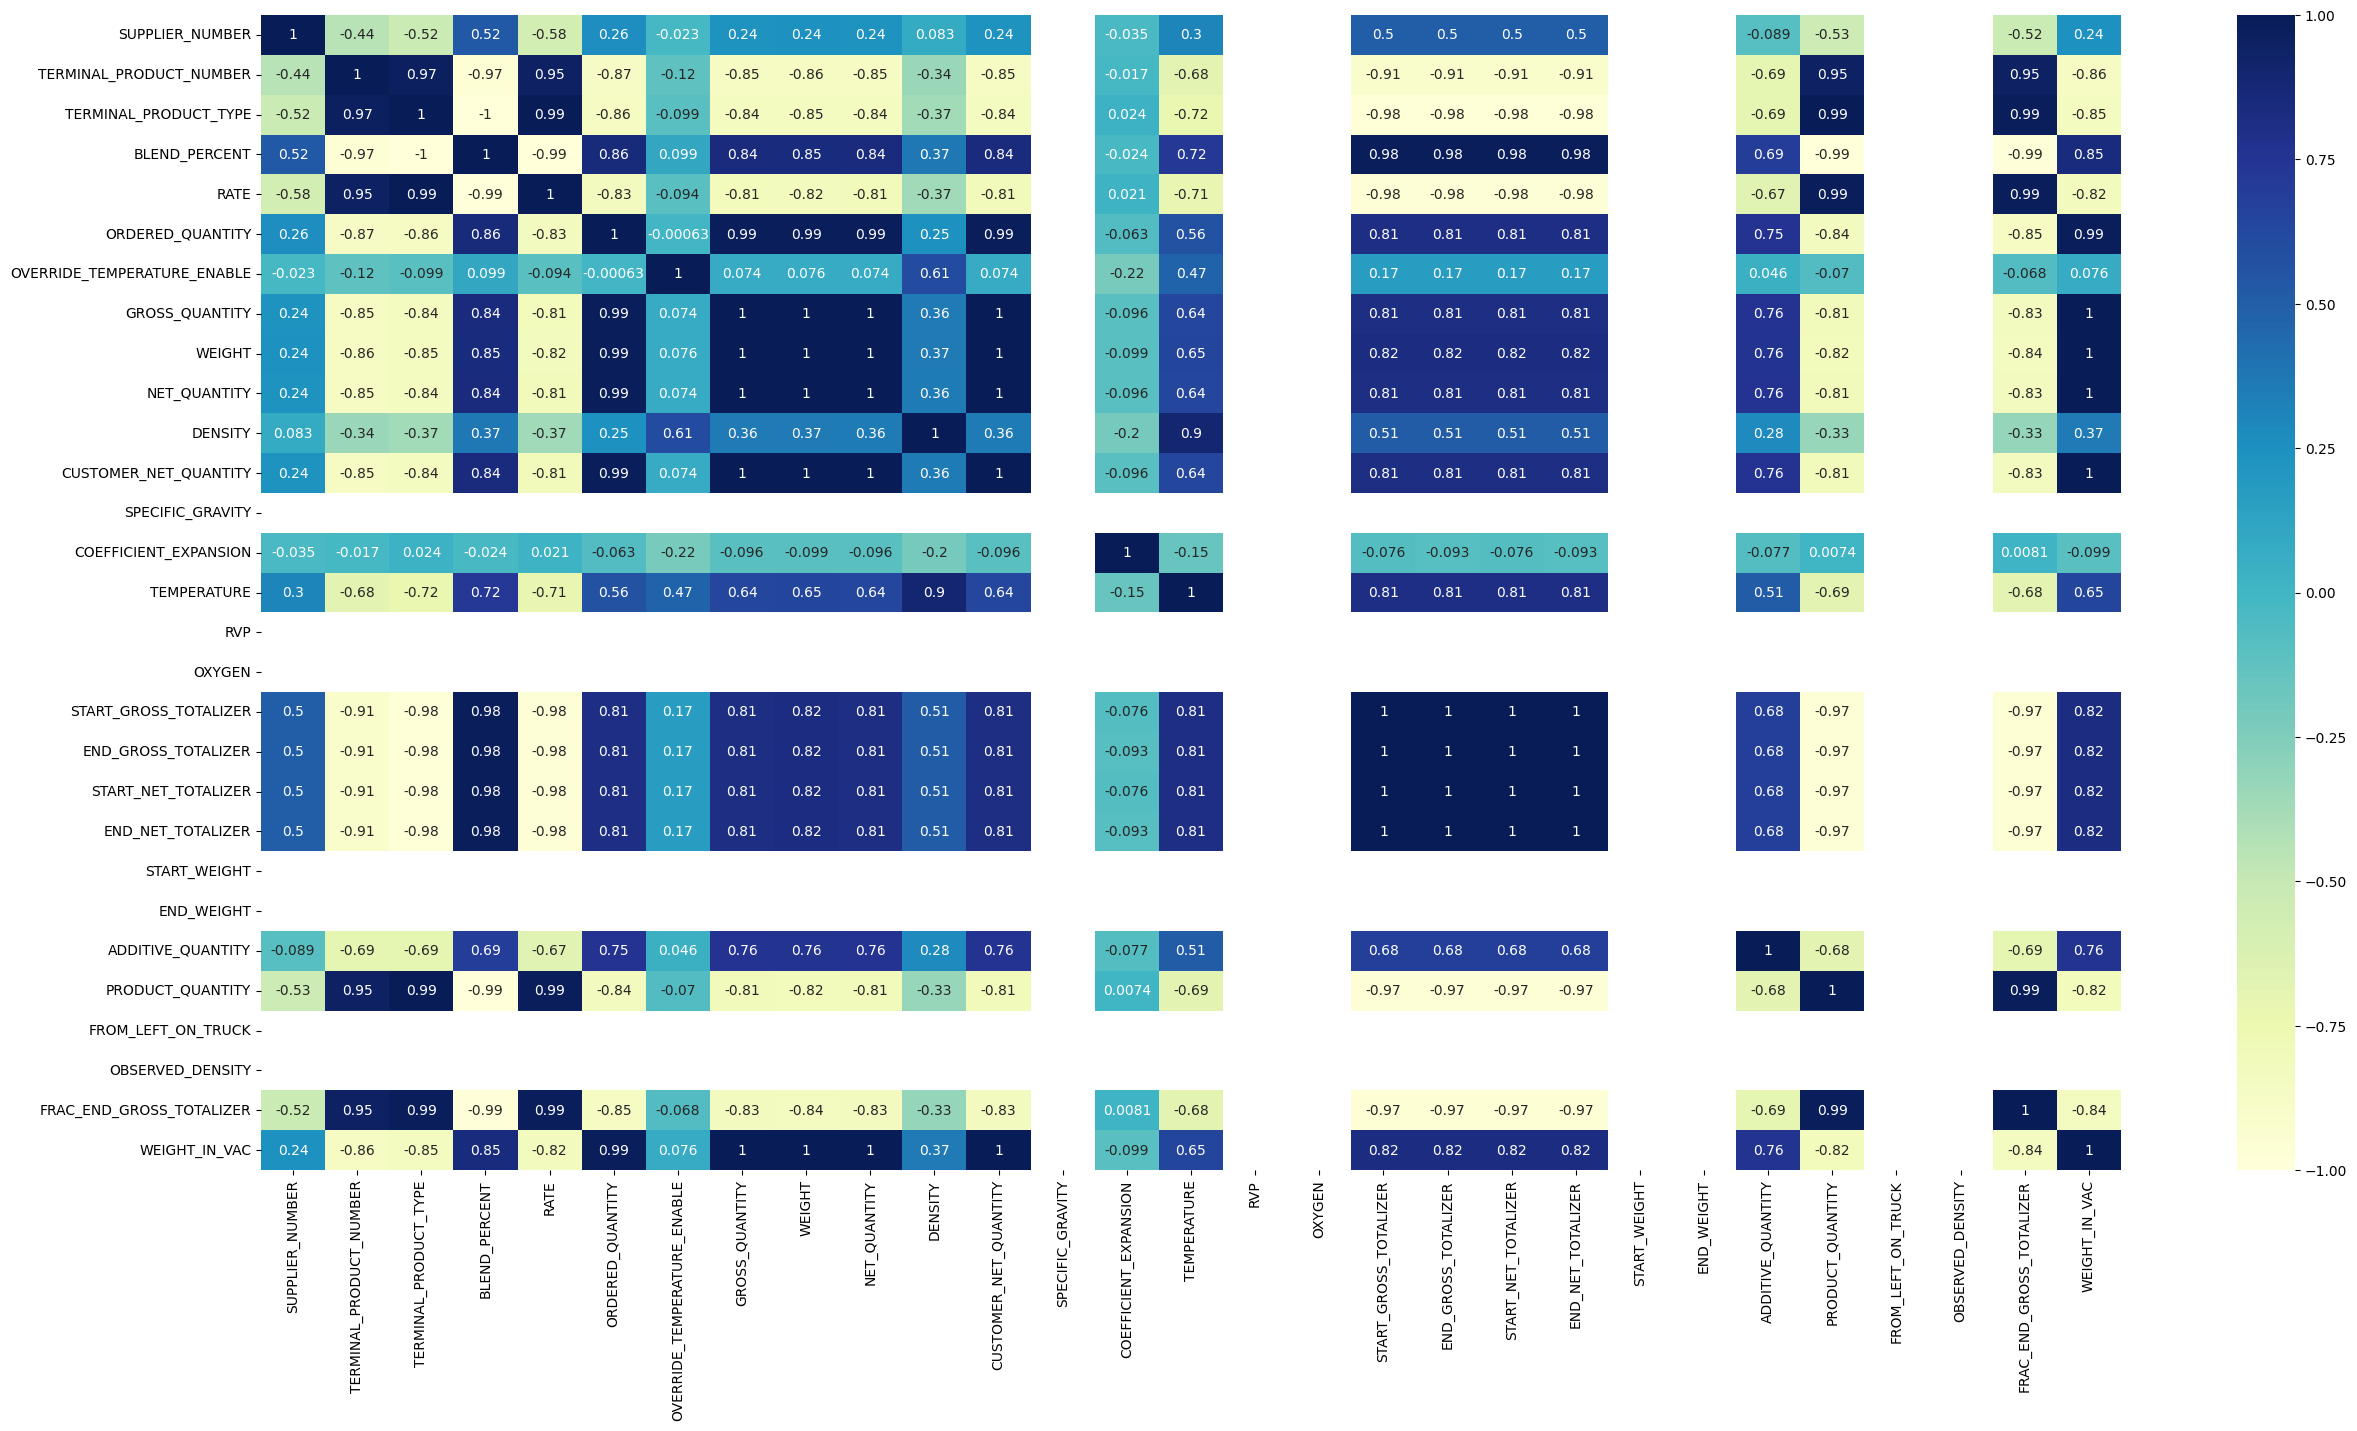

In [32]:
numeric_columns = df1.select_dtypes(include=['number']).columns
corr_matrix = df1[numeric_columns].corr()
plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix.corr(), annot=True, cmap="YlGnBu")

In [33]:
df1 = df1.drop_duplicates()
print(f"Number of duplicate rows: {df1.duplicated().sum()}")

Number of duplicate rows: 0


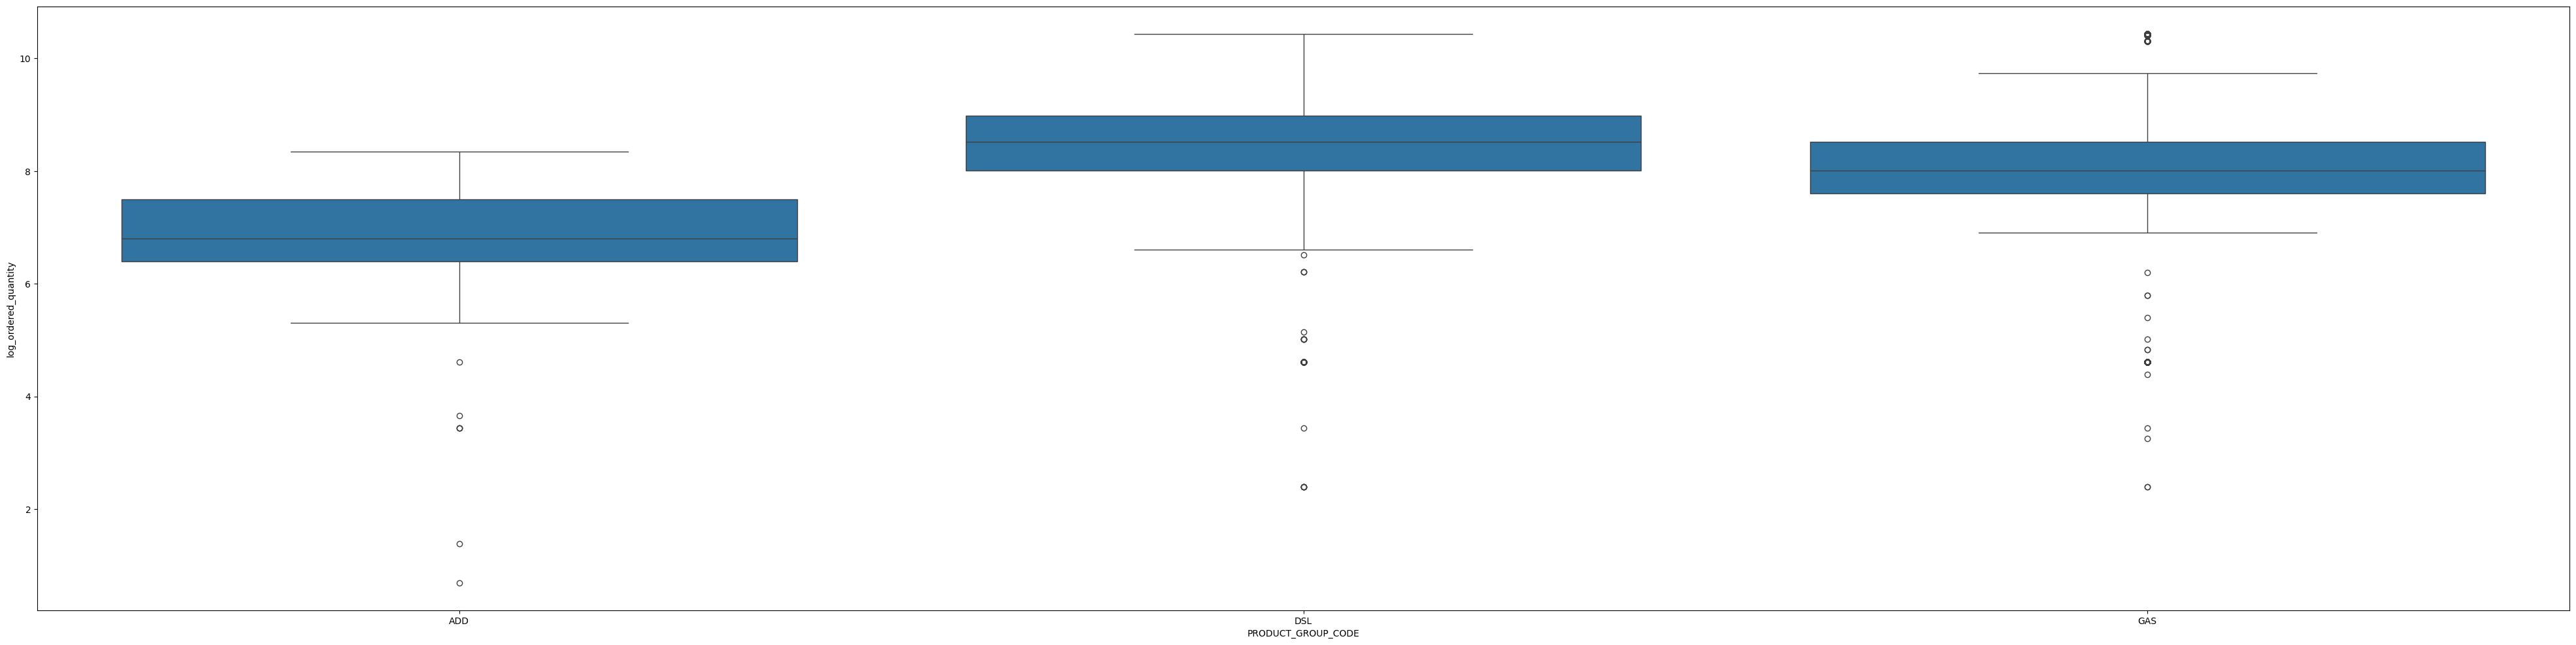

In [34]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12

#Taking subset of data temporarily for in memory compute.⅖
df_temp = df1.sample(n=60000).reset_index()
df_temp['log_ordered_quantity']= np.log1p(df_temp['ORDERED_QUANTITY'])

# Create a boxplot of log ordered quantity by product group code
fig5 = sns.boxplot(
    x="PRODUCT_GROUP_CODE",
    y="log_ordered_quantity",
    data=df_temp,
    order=df_temp['PRODUCT_GROUP_CODE'].sort_values().unique(),)

# Delete temporary dataframe and figure
del df_temp, fig5

In [36]:
df1['START_TIME'].value_counts().sort_values(ascending = False)

START_TIME
2021-12-03 16:48:15    4
2021-10-01 07:21:59    4
2021-11-05 07:27:15    4
2021-11-01 11:15:59    4
2021-11-15 10:12:44    4
                      ..
2021-12-03 15:37:59    1
2021-12-03 15:30:18    1
2021-12-03 15:32:30    1
2021-12-03 15:38:59    1
2021-09-24 14:21:46    1
Name: count, Length: 46090, dtype: int64

In [37]:
missing_percentage = (df1.isnull().sum() / len(df1)) * 100
print(missing_percentage[missing_percentage > 0])

START_TIME    0.676268
END_TIME      0.676268
dtype: float64


In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62696 entries, 3 to 65534
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   PRODUCT_GROUP_CODE           62696 non-null  int64         
 1   SUPPLIER_NUMBER              62696 non-null  int64         
 2   TERMINAL_PRODUCT_NUMBER      62696 non-null  int64         
 3   TERMINAL_PRODUCT_TYPE        62696 non-null  int64         
 4   BLEND_PERCENT                62696 non-null  int64         
 5   RATE                         62696 non-null  int64         
 6   ORDERED_QUANTITY             62696 non-null  int64         
 7   OVERRIDE_TEMPERATURE_ENABLE  62696 non-null  int64         
 8   GROSS_QUANTITY               62696 non-null  int64         
 9   WEIGHT                       62696 non-null  int64         
 10  NET_QUANTITY                 62696 non-null  int64         
 11  DENSITY                      62696 non-null  f

In [39]:
# Forward Fill: fill missing dates with the last observed value
df1['START_TIME'] = df1['START_TIME'].fillna(method='ffill')

In [40]:
df1['START_TIME'] = df1['START_TIME'].dt.date

In [41]:
df1 = df1.dropna(subset=['START_TIME'])

In [42]:
grp=df1['PRODUCT_GROUP_CODE']
# change the PRODUCT_GROUP_CODE column
grp1 = grp.replace({ 'DSL' : 0, 'ADD' : 1 ,'GAS': 2})
# put the new PRODUCT_GROUP_CODE column back
df1['PRODUCT_GROUP_CODE']=grp1

In [43]:
df1.sort_values('START_TIME', inplace=True)
df1['SUPPLIER_NUMBER'].unique()

array([12, 13,  1, 15,  8, 14,  9, 16,  7,  5,  6,  2, 17, 18])

In [44]:
df1['PRODUCT_GROUP_CODE'].unique()

array([0, 2, 1])

In [45]:
print(df1.isnull().any()> 0)

PRODUCT_GROUP_CODE             False
SUPPLIER_NUMBER                False
TERMINAL_PRODUCT_NUMBER        False
TERMINAL_PRODUCT_TYPE          False
BLEND_PERCENT                  False
RATE                           False
ORDERED_QUANTITY               False
OVERRIDE_TEMPERATURE_ENABLE    False
GROSS_QUANTITY                 False
WEIGHT                         False
NET_QUANTITY                   False
DENSITY                        False
CUSTOMER_NET_QUANTITY          False
SPECIFIC_GRAVITY               False
COEFFICIENT_EXPANSION          False
TEMPERATURE                    False
RVP                            False
OXYGEN                         False
START_GROSS_TOTALIZER          False
END_GROSS_TOTALIZER            False
START_NET_TOTALIZER            False
END_NET_TOTALIZER              False
START_WEIGHT                   False
END_WEIGHT                     False
START_TIME                     False
END_TIME                        True
ADDITIVE_QUANTITY              False
P

In [46]:
df1['START_TIME'] = pd.to_numeric(df1['START_TIME'],errors='coerce')

In [47]:
df1

,PRODUCT_GROUP_CODE,SUPPLIER_NUMBER,TERMINAL_PRODUCT_NUMBER,TERMINAL_PRODUCT_TYPE,BLEND_PERCENT,RATE,ORDERED_QUANTITY,OVERRIDE_TEMPERATURE_ENABLE,GROSS_QUANTITY,WEIGHT,...,START_WEIGHT,END_WEIGHT,START_TIME,END_TIME,ADDITIVE_QUANTITY,PRODUCT_QUANTITY,FROM_LEFT_ON_TRUCK,OBSERVED_DENSITY,FRAC_END_GROSS_TOTALIZER,WEIGHT_IN_VAC
3,0,12,7,1,100,0,671,2,672,548,...,0,0,NaN,2021-09-24 14:23:10,0,0,2,0,0,548
7,0,13,7,1,100,0,8000,0,0,0,...,0,0,NaN,NaT,0,0,2,0,0,0
8,2,13,4,1,100,0,3000,0,0,0,...,0,0,NaN,NaT,0,0,2,0,0,0
9,0,13,7,1,100,0,2000,0,0,0,...,0,0,NaN,NaT,0,0,2,0,0,0
10,2,13,4,1,100,0,4000,0,0,0,...,0,0,NaN,NaT,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65037,0,1,7,1,100,0,2000,2,1997,1644,...,0,0,NaN,2021-12-17 08:27:36,601,0,2,0,0,1646
65038,1,1,8,2,0,300,600,2,601,480,...,0,0,NaN,2021-12-17 08:27:36,0,1997,2,0,485,481
65039,0,1,7,1,100,0,6000,2,6000,4941,...,0,0,NaN,2021-12-17 08:27:34,1797,0,2,0,0,4948
65041,0,14,7,1,100,0,8000,2,7997,6585,...,0,0,NaN,2021-12-17 08:25:24,0,0,2,0,0,6594


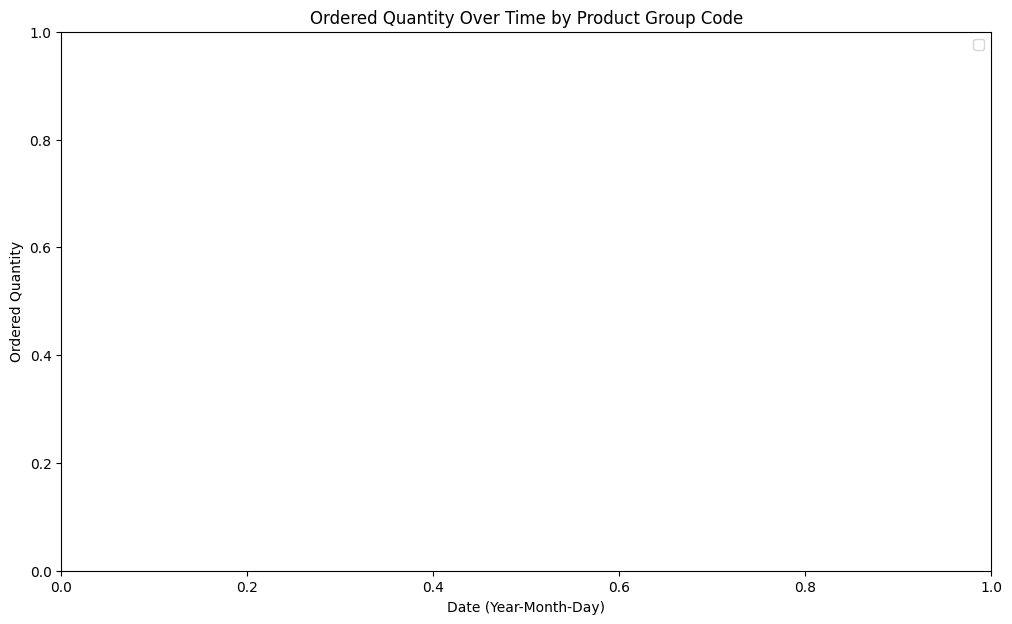

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'START_TIME' column to datetime format
df1['START_TIME'] = pd.to_datetime(df1['START_TIME'])

# Round 'START_TIME' to the nearest week (without considering hours)
df1['START_TIME'] = df1['START_TIME'].dt.to_period('W').dt.to_timestamp()

# Format 'START_TIME' to display only month and day
df1['START_TIME'] = df1['START_TIME'].dt.strftime('%Y-%m-%d')

# Group by 'PRODUCT_GROUP_CODE', resample to a larger time interval (weekly), and sum the quantities
grouped = df1.groupby(['PRODUCT_GROUP_CODE', 'START_TIME'])['ORDERED_QUANTITY'].sum()

# Plot each group
fig, ax = plt.subplots(figsize=(12, 7))
for name, group in grouped.groupby(level=0):  # Iterate over groups
    group.plot(ax=ax, label=f"Product Group Code: {name}")

plt.title('Ordered Quantity Over Time by Product Group Code')
plt.xlabel('Date (Year-Month-Day)')
plt.ylabel('Ordered Quantity')
plt.legend()
plt.show()


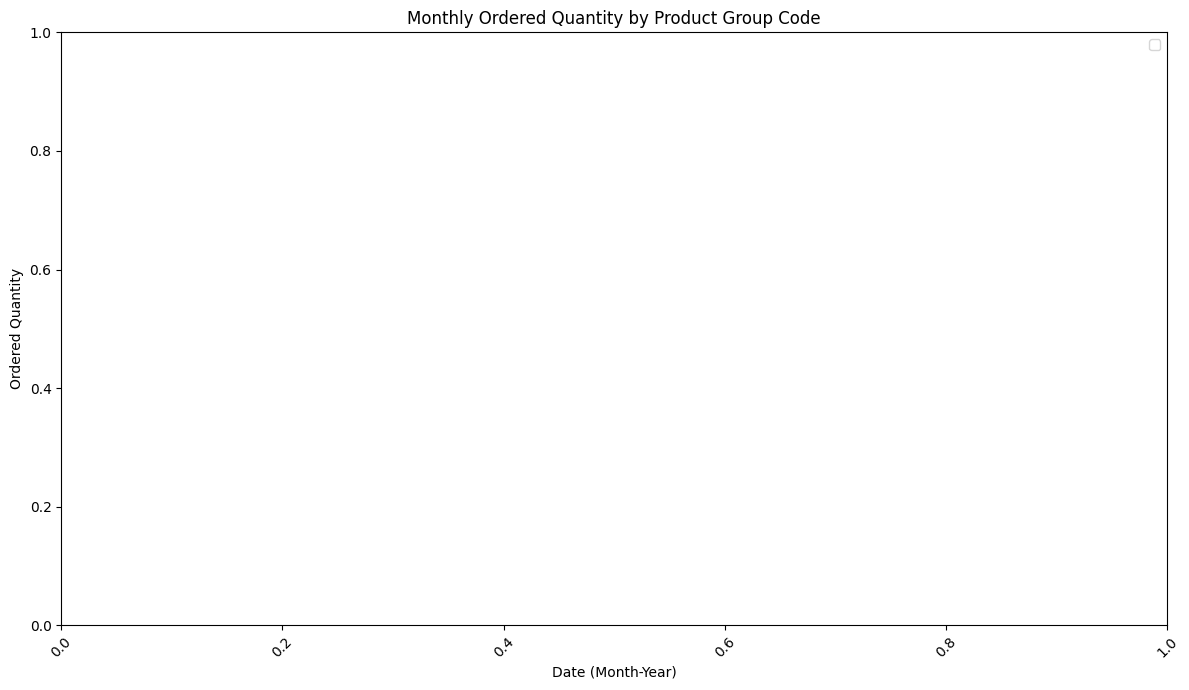

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'START_TIME' is in datetime format
df1['START_TIME'] = pd.to_datetime(df1['START_TIME'])

# Convert 'START_TIME' to a "Year-Month" string format
df1['START_TIME_YM'] = df1['START_TIME'].dt.strftime('%m-%Y')

# You don't need to set START_TIME_YM as an index for grouping in this case
# Group by 'PRODUCT_GROUP_CODE' and the new 'START_TIME_YM'
grouped = df1.groupby(['PRODUCT_GROUP_CODE', 'START_TIME_YM'])['ORDERED_QUANTITY'].sum().reset_index()

# Plot each group
fig, ax = plt.subplots(figsize=(12, 7))
# Unique product codes for legend
product_group_codes = grouped['PRODUCT_GROUP_CODE'].unique()

for product_code in product_group_codes:
    # Filter the grouped DataFrame for each product code
    group = grouped[grouped['PRODUCT_GROUP_CODE'] == product_code]
    ax.plot(group['START_TIME_YM'], group['ORDERED_QUANTITY'], label=product_code)

plt.title('Monthly Ordered Quantity by Product Group Code')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Ordered Quantity')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


<Axes: xlabel='START_TIME'>

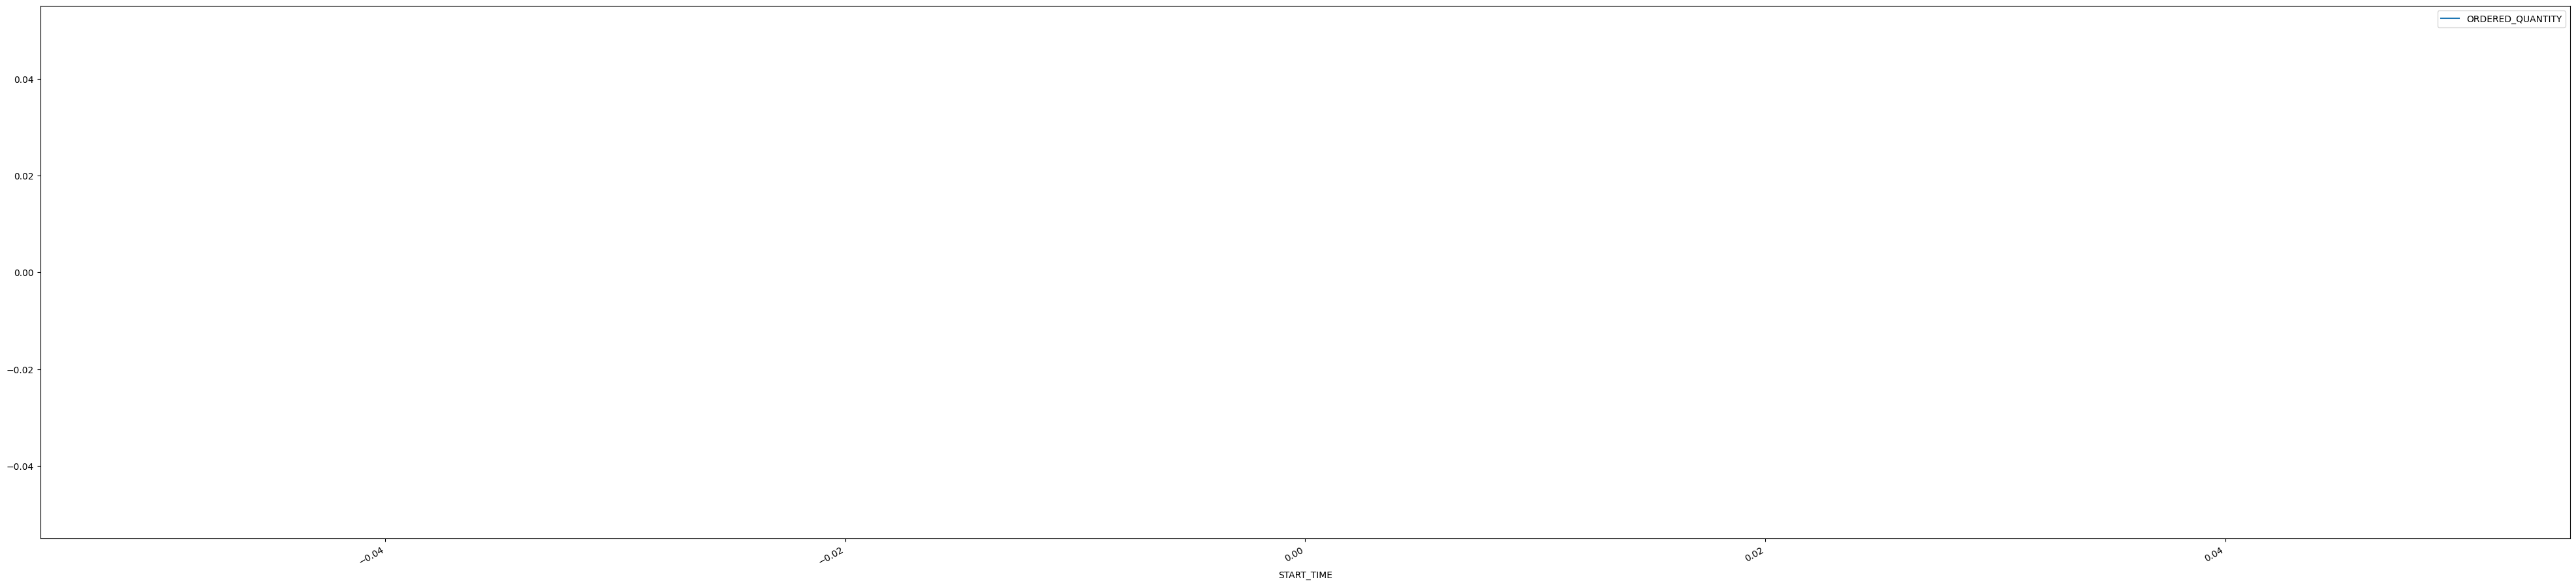

In [51]:
# @title Ordered Quantity over Time

df1.plot.line(x='START_TIME', y='ORDERED_QUANTITY')

In [80]:
# Define the columns to keep
columns_to_keep = ['SUPPLIER_NUMBER', 'ORDERED_QUANTITY', 'ADDITIVE_QUANTITY', 'START_TIME', 'END_TIME']

# Create a copy of the dataframe with only the selected columns
df_subset = df1[columns_to_keep].copy()


In [90]:
# Define features and target variable
y = df_subset['ORDERED_QUANTITY']
X = df_subset['SUPPLIER_NUMBER']

In [95]:
df_subset

,SUPPLIER_NUMBER,ORDERED_QUANTITY,ADDITIVE_QUANTITY,START_TIME,END_TIME
3,12,671,0,NaT,2021-09-24 14:23:10
7,13,8000,0,NaT,NaT
8,13,3000,0,NaT,NaT
9,13,2000,0,NaT,NaT
10,13,4000,0,NaT,NaT
...,...,...,...,...,...
65037,1,2000,601,NaT,2021-12-17 08:27:36
65038,1,600,0,NaT,2021-12-17 08:27:36
65039,1,6000,1797,NaT,2021-12-17 08:27:34
65041,14,8000,0,NaT,2021-12-17 08:25:24


In [109]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape X_train to 2D array if it has a single feature
X_train = X_train.values.reshape(-1, 1)

# Reshape y_train to 2D array if it contains a single sample
y_train = y_train.values.reshape(-1, 1)



In [111]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test.values.reshape(-1, 1))


In [112]:
# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 2578.0122389154026


In [115]:
from sklearn.tree import DecisionTreeRegressor

# Model Training
model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(X_train.reshape(-1, 1), y_train)
y_pred = model.predict(X_test.values.reshape(-1, 1))


In [116]:
# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 2576.702674639222


In [123]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.9 MB/s eta 0:00:00


In [127]:
pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00


In [128]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# Create a list of models and instantiation parameters
models = [
    AutoARIMA(),
    ExponentialSmoothing(),
    NaiveForecaster(strategy="last"),
    ThetaForecaster(sp=12),
    PolynomialTrendForecaster(degree=1)
]


In [133]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.performance_metrics.forecasting import smape_loss

# Define the parameter grid for grid search
param_grid = {
    "model": models,
    "window_length": [12, 24],  # Change window length as needed
}

# Instantiate SlidingWindowSplitter for cross-validation
cv = SlidingWindowSplitter(initial_window=36, window_length=12, start_with_window=True)

# Instantiate ForecastingGridSearchCV
grid_search = ForecastingGridSearchCV(estimator=None, param_grid=param_grid, cv=cv, verbose=True, n_jobs=-1, scoring=smape_loss)

# Fit the grid search
grid_search.fit(your_training_data)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make forecasts using the best model
forecasts = best_model.predict(steps=your_forecast_steps)


ImportError: cannot import name 'smape_loss' from 'sktime.performance_metrics.forecasting' (/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/__init__.py)

In [59]:
forecasts_df = sf.forecast(h=14, level=[90])

forecasts_df

NameError: name 'sf' is not defined

In [60]:
crossvaldation_df = sf.cross_validation(
    df=High,
    h=14,
    step_size=2,
    n_windows=14
  )
crossvaldation_df

NameError: name 'sf' is not defined

In [ ]:
# Filter the dataset to only include the desired oil product categories
df_filtered = df1[df1['PRODUCT_GROUP_CODE'].isin(['GAS', 'DSL', 'ADD'])]

# Set the TIME column as the index
df_filtered.set_index('START_TIME', inplace=True)

# Plot the time series line graph
df_filtered.plot(x='START_TIME', y='ORDERED_QUANTITY', kind='line')

# Add axis labels
plt.xlabel('Time')
plt.ylabel('Ordered Quantity')

# Display the plot
plt.show()